# **Building a Pytorch Classification model**

In [1]:
import pandas as pd 
import numpy as np 
import torch 
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## **Setting the Gpu**

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **importing the data**

In [3]:
df = pd.read_csv('/kaggle/input/rice-type-classification/riceClassification.csv')

In [4]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
df.shape

(18185, 12)

In [6]:
df.dtypes

id                   int64
Area                 int64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
ConvexArea           int64
EquivDiameter      float64
Extent             float64
Perimeter          float64
Roundness          float64
AspectRation       float64
Class                int64
dtype: object

<Axes: >

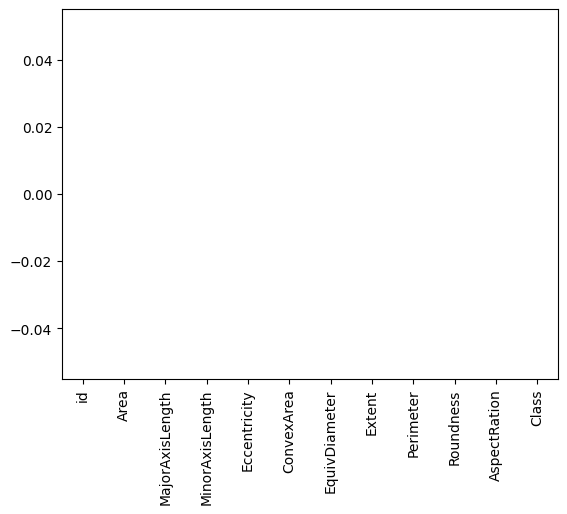

In [7]:
df.isna().sum().plot(kind='bar')

In [8]:
df.duplicated().sum()

0

In [9]:
df.drop(df.columns[0],axis=1,inplace=True)

Text(0.5, 1.0, 'Distribution of our target variable')

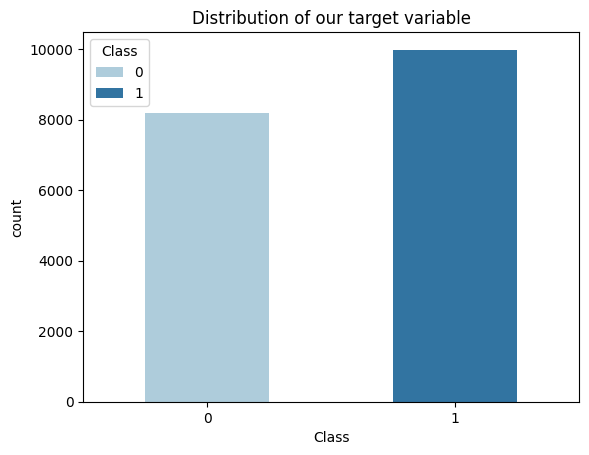

In [10]:
sns.countplot(x=df['Class'],hue=df['Class'],palette='Paired',dodge=False,width=0.5)
plt.title('Distribution of our target variable')

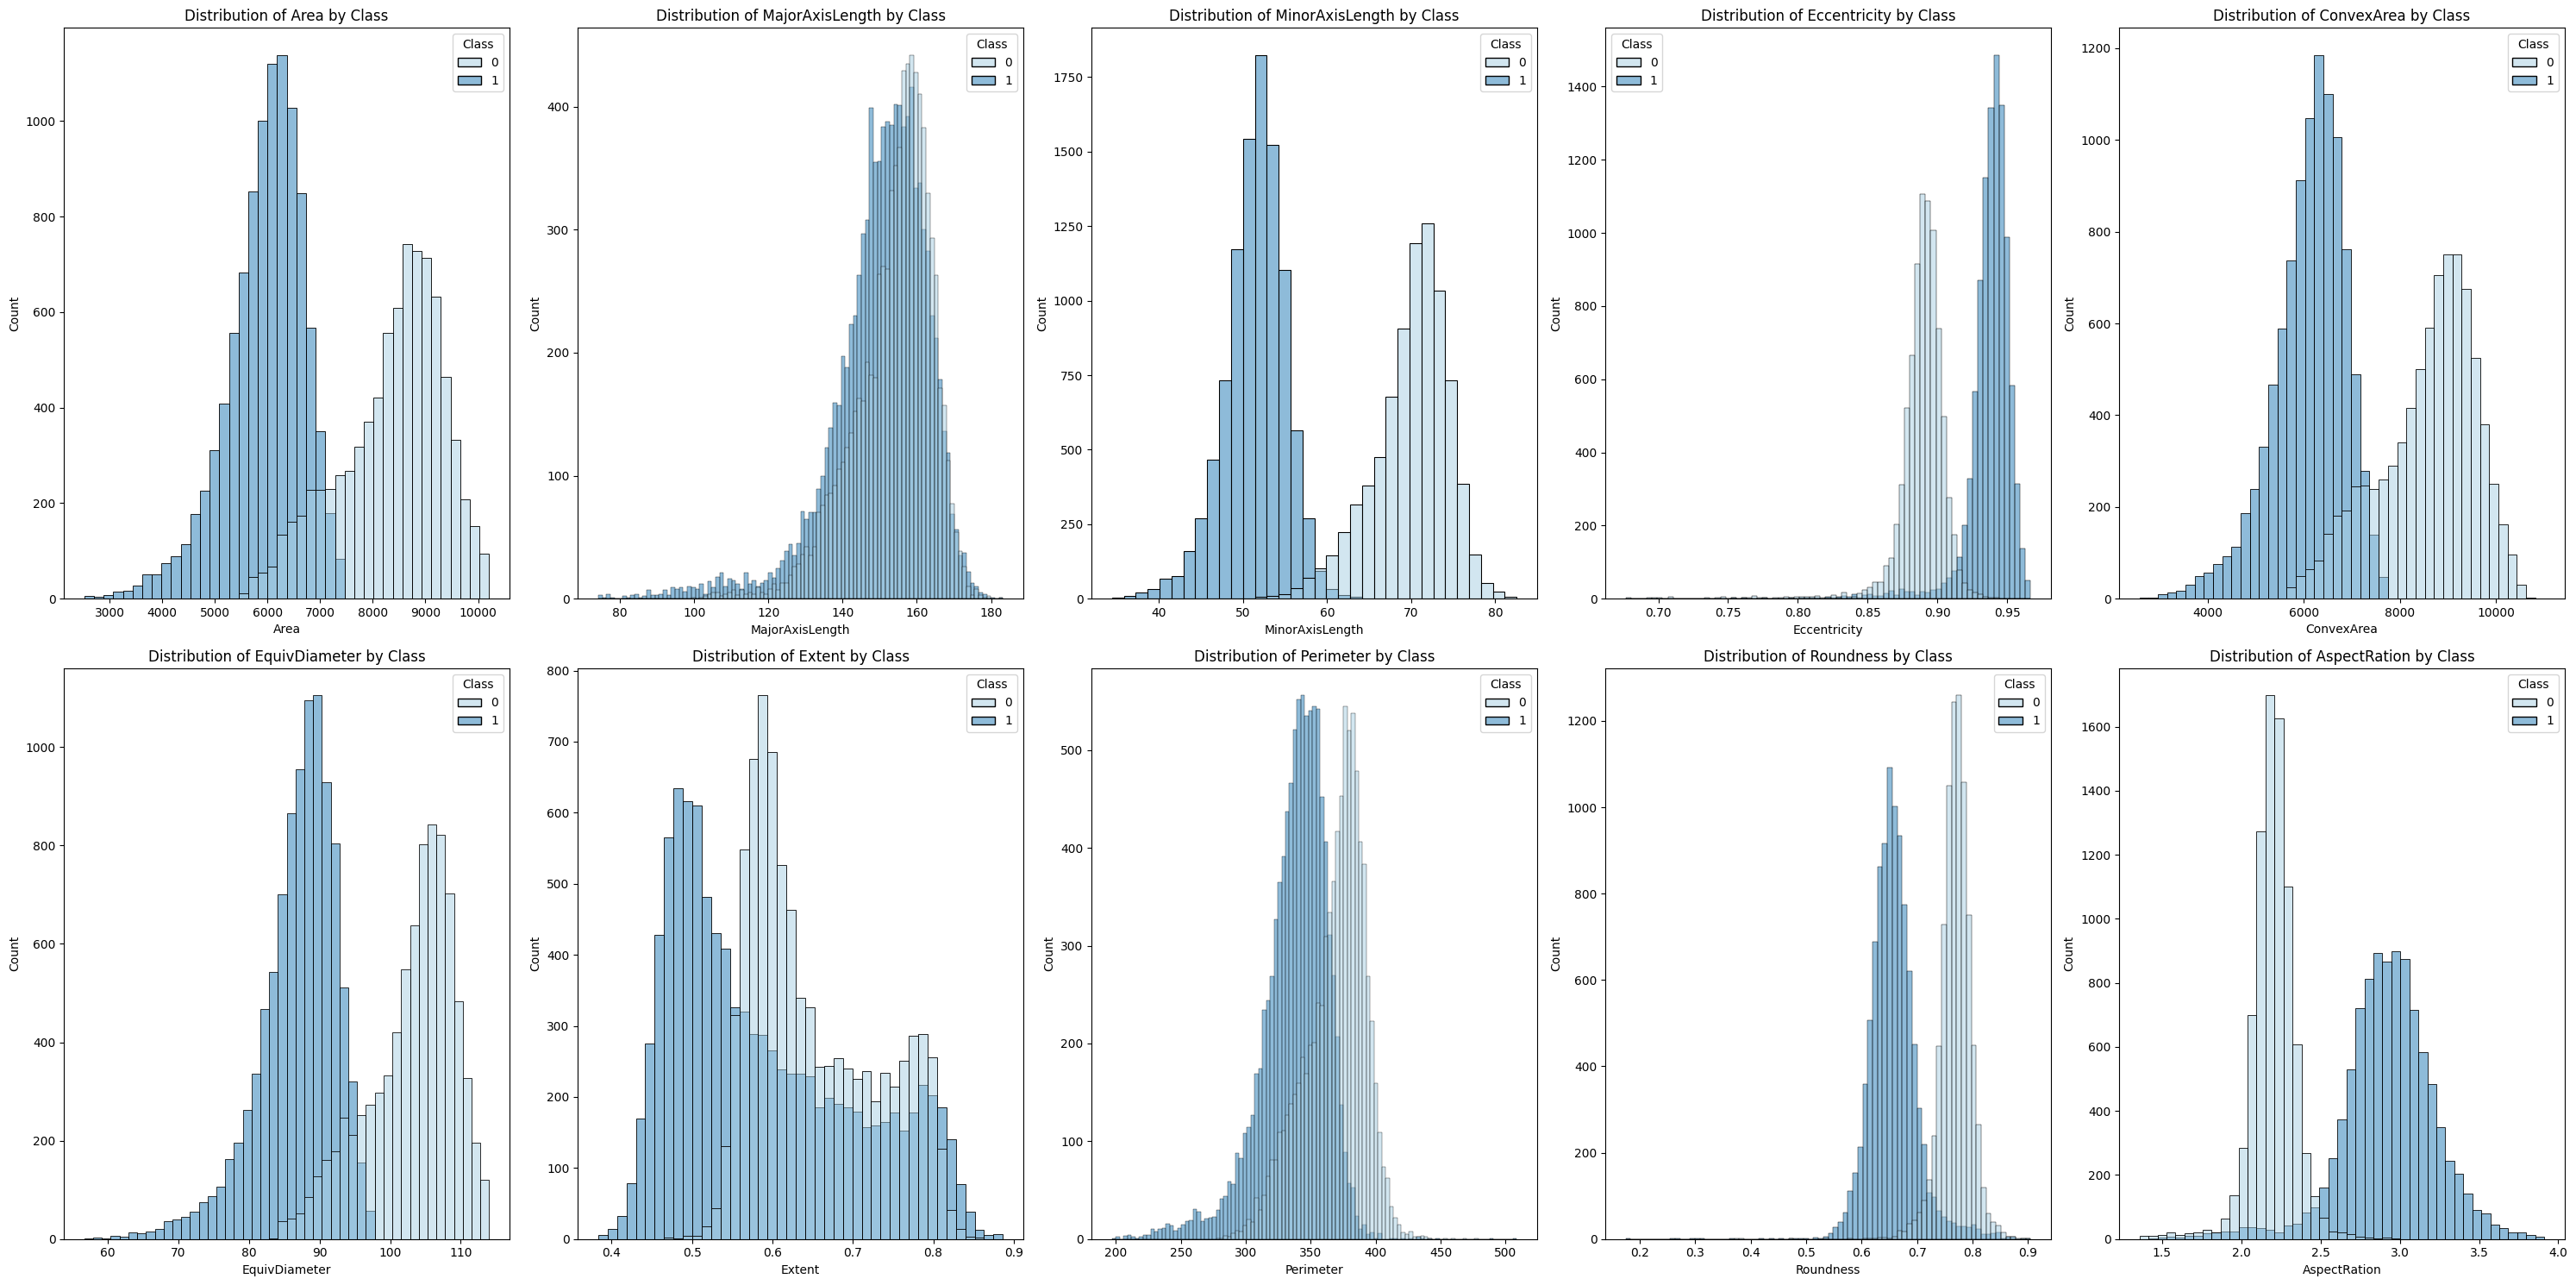

In [11]:
fig , ax = plt.subplots(2,5,figsize=(30,15))
ax = ax.flatten()

for i , col in enumerate(df.columns[:-1]):
    sns.histplot(x=df[col],hue=df['Class'],palette='Paired',ax=ax[i],alpha=0.5)
    ax[i].set_title(f'Distribution of {col} by Class')
plt.tight_layout()

In [12]:
df_1 = df.copy()

## **Data Preprocessing**

*so as we can see our columns have different scales some goes from 0 to 1 an others goes from 4000 to 10000 , which can lead to instability in our model optimizer to converge also the columns with big scales will dominante because they have strong magnitude so to fix this we will use a normalisation techniques that will Improves overall model performance by making sure all features contribute equally .*

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
Scaler = MinMaxScaler()
df_1 = pd.DataFrame(Scaler.fit_transform(df_1),columns = df.columns)

In [15]:
df_1

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.262097,0.165901,0.614922,0.149139,0.248903,0.337191,0.544960,0.244209,0.807934,0.032371,1.0
1,0.045525,0.005123,0.352934,0.168567,0.051726,0.066336,0.655171,0.036283,0.899898,0.037204,1.0
2,0.068418,0.019803,0.366292,0.188069,0.065607,0.098164,0.746848,0.041724,0.950265,0.042222,1.0
3,0.071670,0.026591,0.363903,0.213671,0.068573,0.102609,0.795277,0.043795,0.952688,0.049077,1.0
4,0.152315,0.100769,0.456247,0.250355,0.145094,0.207586,0.767156,0.106958,0.958906,0.059471,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18180,0.433273,0.682917,0.345224,0.904994,0.406810,0.517174,0.229182,0.436426,0.669518,0.608684,0.0
18181,0.658559,0.875159,0.492965,0.905642,0.620121,0.725477,0.524943,0.605115,0.639275,0.610397,0.0
18182,0.499870,0.739322,0.384251,0.906891,0.468858,0.581631,0.353738,0.466260,0.696071,0.613720,0.0
18183,0.447190,0.708342,0.354474,0.909189,0.428283,0.530871,0.216874,0.469849,0.630873,0.619915,0.0


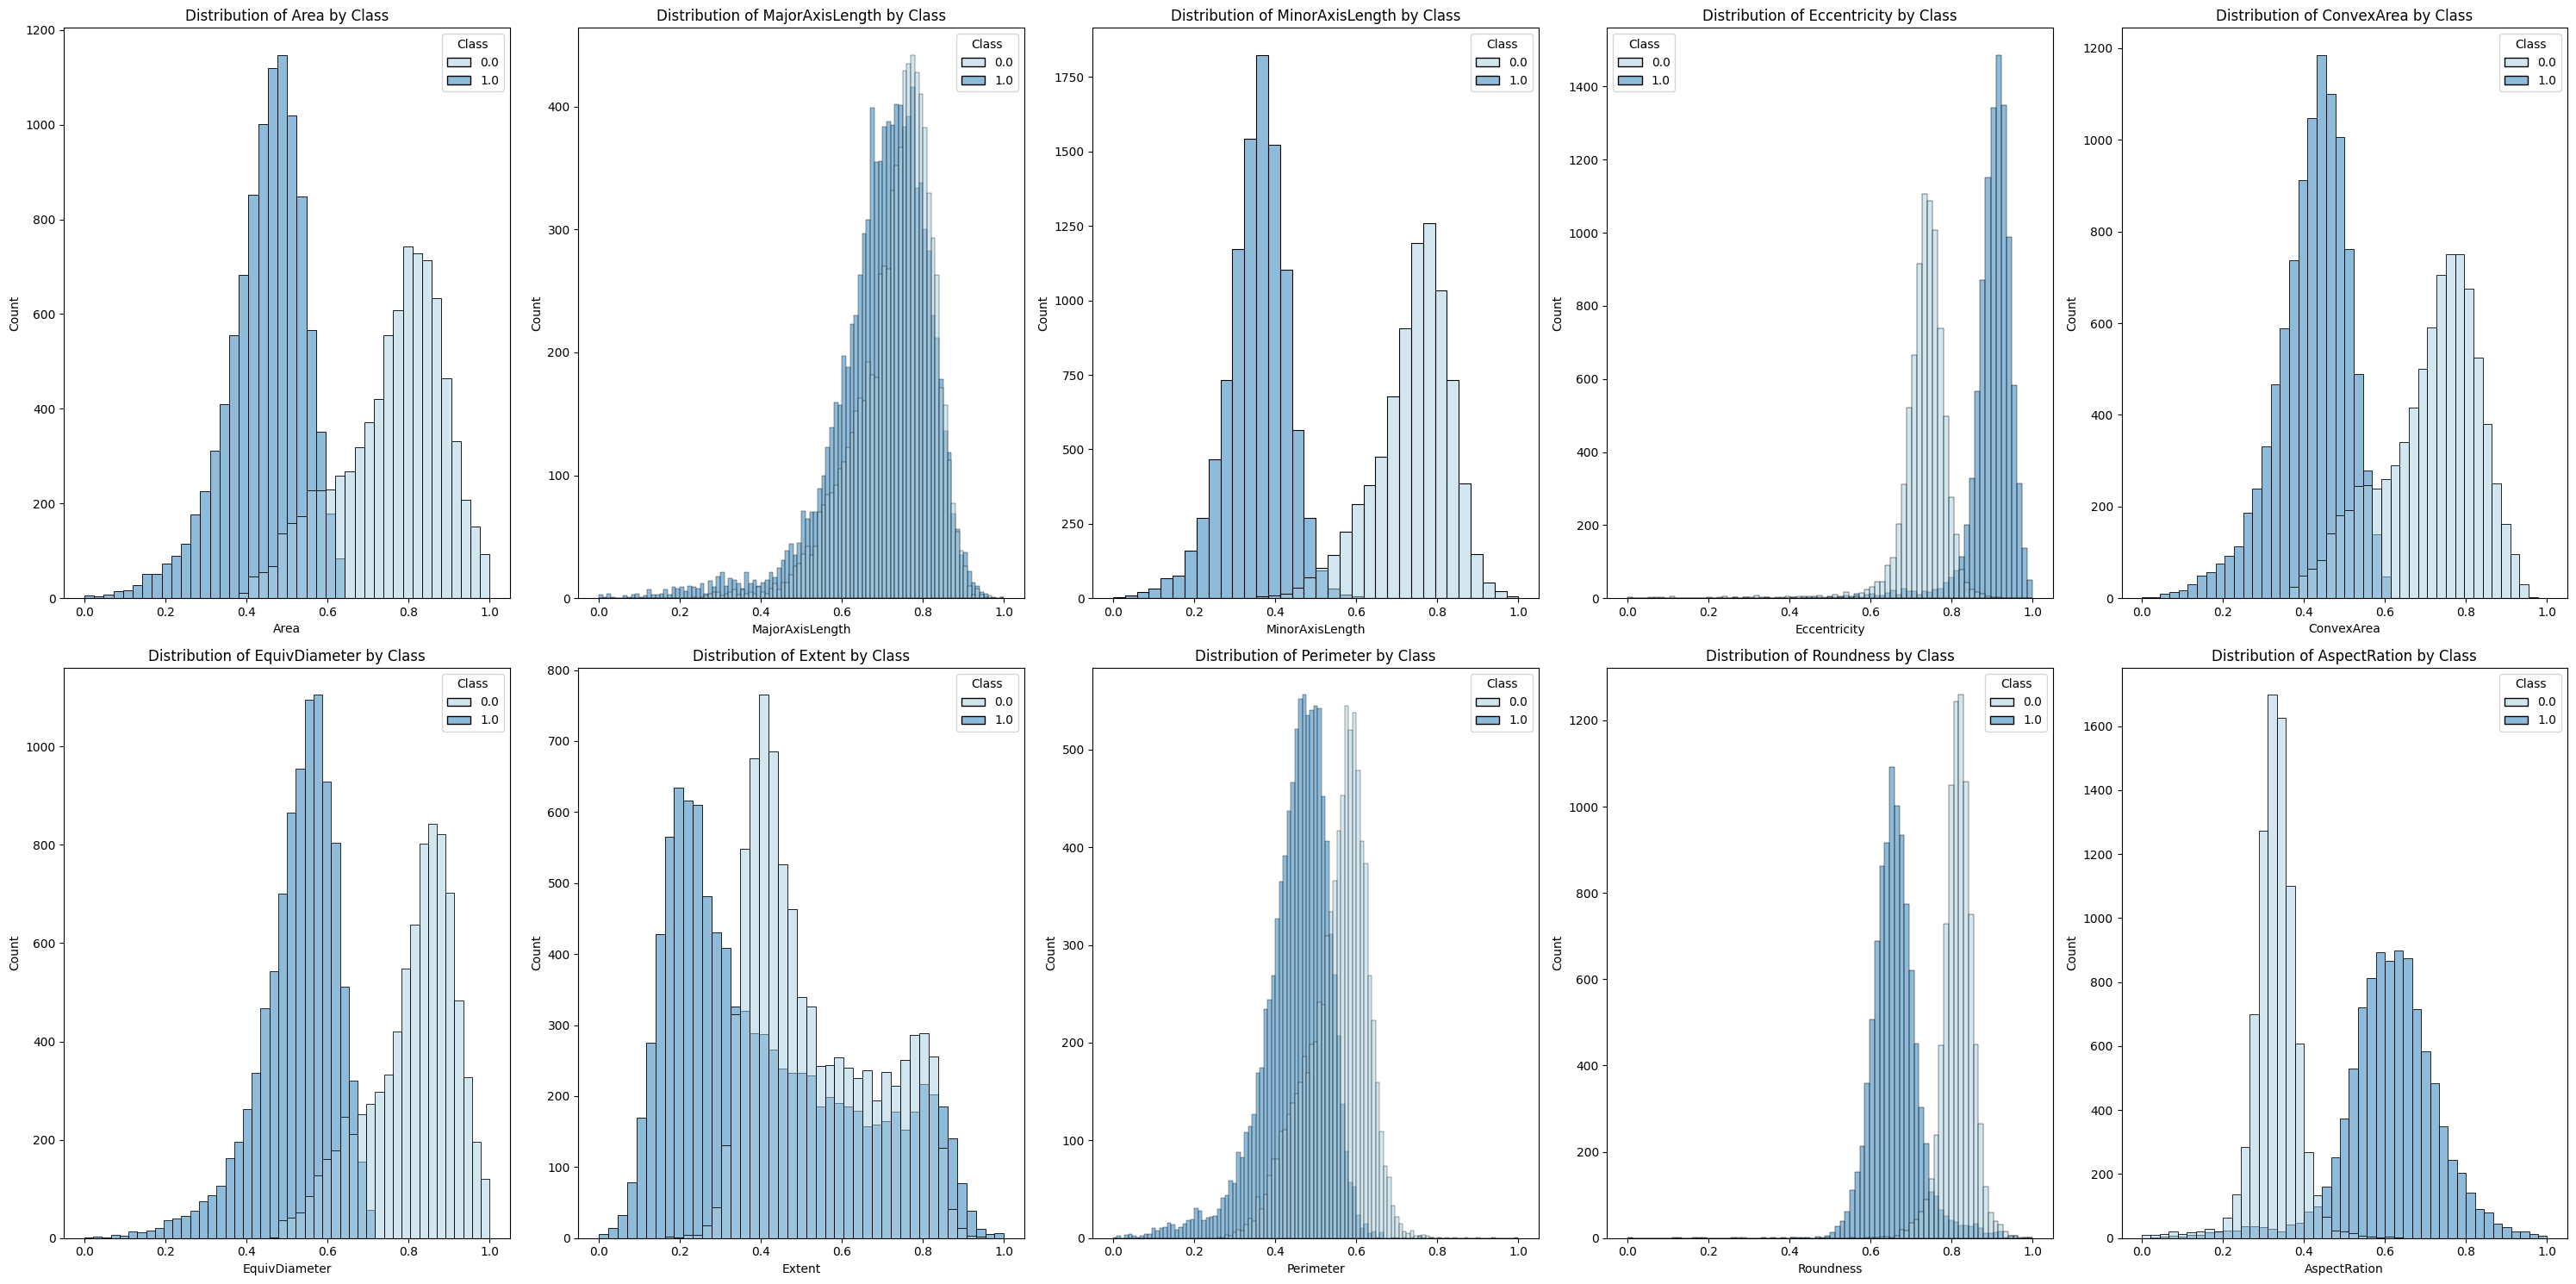

In [16]:
fig , ax = plt.subplots(2,5,figsize=(30,15))
ax = ax.flatten()

for i , col in enumerate(df_1.columns[:-1]):
    sns.histplot(x=df_1[col],hue=df_1['Class'],palette='Paired',ax=ax[i],alpha=0.5)
    ax[i].set_title(f'Distribution of {col} by Class')
plt.tight_layout()

* Note :
  - we can see that we conserve the same distribution the only changes are in the scale and the range of the data

### **spliting the data**

In [17]:
X = np.array(df_1.iloc[:,:-1])
y = np.array(df_1.iloc[:,-1])

In [18]:
print('the shape of X :',X.shape ) 
print('the shape of y :',X.shape )

the shape of X : (18185, 10)
the shape of y : (18185, 10)


In [19]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_test , X_val , y_test , y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

In [20]:
100 / 8

12.5

In [21]:
print('the shape of X_train :', X_train.shape ) 
print('the shape of y_train :',  y_train.shape )
print('the shape of X_test :', X_test.shape )
print('the shape of y_test :', y_test.shape )
print('the shape of X_val :', X_val.shape )
print('the shape of y_val :', y_val.shape )




the shape of X_train : (12729, 10)
the shape of y_train : (12729,)
the shape of X_test : (2728, 10)
the shape of y_test : (2728,)
the shape of X_val : (2728, 10)
the shape of y_val : (2728,)


In [22]:
class dataset(Dataset):
    def __init__(self,X,y):
        self.X= torch.tensor(X,dtype= torch.float32).to(device)
        self.y= torch.tensor(y,dtype= torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self,index):
        return self.X[index] ,self.y[index]

In [23]:
train_data = dataset(X_train , y_train)
test_data = dataset(X_test,y_test)
val_data = dataset(X_val, y_val)

In [24]:
train_data_loader = DataLoader(train_data,batch_size=32,shuffle=8)
test_data_loader = DataLoader(test_data,batch_size=32,shuffle=8)
val_data_loader = DataLoader(val_data,batch_size=32,shuffle=8)

## **Building the model**

In [25]:
hidden_neurons = 10
class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel,self).__init__()
        self.input_layer = nn.Linear(X.shape[1],hidden_neurons)
        self.linear = nn.Linear(hidden_neurons,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = Mymodel().to(device) 
criterion = nn.BCELoss() # binary cross entropy
optmizer = Adam(model.parameters(),lr = 1e-3)

In [26]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


 ### **Creating the training loop**

In [27]:
loss_train_list = []
loss_val_list = []
acc_train_list = []
acc_val_list = []

epochs = 10
for ep in range(epochs):
 
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0
#batch level     
#training    
    for data in train_data_loader:
        inputs , labels = data
        preds = model(inputs).squeeze(1)
        # loss  
        batch_loss = criterion(preds,labels)
        total_loss_train += batch_loss.item()
        #accuracy 
        acc = (preds.round() == labels).sum().item()
        total_acc_train += acc
        # loss function and optimization 
        batch_loss.backward()
        optmizer.step()
        optmizer.zero_grad()
        
#validation          
    with torch.inference_mode():       
         for data in val_data_loader:
             #prediction
             inputs , labels = data
             preds = model(inputs).squeeze(1)
             # loss
             batch_loss = criterion(preds,labels).item()
             total_loss_val += batch_loss
             # accuracy
             acc = (preds.round() == labels).sum().item()
             total_acc_val += acc
          
    loss_train_list.append(round(total_loss_train/1000,4))
    loss_val_list.append(round(total_loss_val/1000,4))
#getting the status
    acc_train_list.append(round(total_acc_train/train_data.__len__() * 100,4))
    acc_val_list.append(round(total_acc_val/val_data.__len__() * 100,4))
    print(f'''\n epoch : {ep+1} | Train loss :{round(total_loss_train/1000,4)} | train accuracy : {round(total_acc_train/train_data.__len__() * 100,4)} | val loss : {round(total_loss_val/1000,4)} | val accuracy : {round(total_acc_val/val_data.__len__() * 100,4)} ''')       
    print("="*100)        


 epoch : 1 | Train loss :0.2241 | train accuracy : 85.7884 | val loss : 0.0275 | val accuracy : 98.2771 

 epoch : 2 | Train loss :0.0713 | train accuracy : 98.2324 | val loss : 0.0088 | val accuracy : 98.607 

 epoch : 3 | Train loss :0.0327 | train accuracy : 98.4052 | val loss : 0.0057 | val accuracy : 98.5704 

 epoch : 4 | Train loss :0.0243 | train accuracy : 98.4838 | val loss : 0.0048 | val accuracy : 98.5337 

 epoch : 5 | Train loss :0.021 | train accuracy : 98.4916 | val loss : 0.0044 | val accuracy : 98.5337 

 epoch : 6 | Train loss :0.0195 | train accuracy : 98.5623 | val loss : 0.0043 | val accuracy : 98.3871 

 epoch : 7 | Train loss :0.0186 | train accuracy : 98.5231 | val loss : 0.0043 | val accuracy : 98.2771 

 epoch : 8 | Train loss :0.0182 | train accuracy : 98.4995 | val loss : 0.004 | val accuracy : 98.5337 

 epoch : 9 | Train loss :0.0178 | train accuracy : 98.5623 | val loss : 0.004 | val accuracy : 98.4971 

 epoch : 10 | Train loss :0.0177 | train accuracy